# 15 · Shifted vs. Unshifted Inter‑Subject RSA

**Aim.** Compare parcel‑wise inter‑subject alignment computed with (i) **temporal shifting** (IS‑1; removes trial‑locked noise) and (ii) **no shift** (IS‑0). We (a) visualise both maps, (b) quantify their relation with a power‑law fit, and (c) report parcel correlations.


## 1. Imports & setup

Load plotting/stat modules, cortical mapping helpers, and initialise fonts/colorbars.


In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from convergence.plotting import plot_faverage_parcelation
from convergence.figures import plot_cbar_set, setup_matplotlib_fonts
from convergence.power_law import fit_powerlaw_zero_with_bootstrap


setup_matplotlib_fonts()

## 2. Data paths

- HCP atlas (`hcp.csv`)  
- IS‑0 (`rsa_subject_subject_alignment_joined_0.parquet`)  
- IS‑1 (`rsa_subject_subject_alignment_shift_1_joined.parquet`)  
Create an output directory: `figures/15_shifted_vs_unshifted_rsa/`.


In [2]:
data_folder = Path("../derivatives")

hcp_filename = data_folder / "metadata" / "hcp.csv"
filename_rsa_0 = data_folder / "nsd" / "rsa_subject_subject_alignment_joined_0.parquet"
filename_rsa_1 = data_folder / "nsd" / "rsa_subject_subject_alignment_shift_1_joined.parquet"
filename_rsa_2 = data_folder / "nsd" / "rsa_subject_subject_alignment_shift_2_joined.parquet"

figures_folder = Path("../figures")
output_folder = figures_folder / "15_shifted_vs_unshifted_rsa"
output_folder.mkdir(exist_ok=True, parents=True)

## 3. Group‑level RSA extraction

For each file:

- Keep **diagonal** ROI pairs (`roi_x == roi_y`)  
- Restrict to **different subjects** (`subject_i ≠ subject_j`)  
- Average across all subject pairs → one value per ROI

Merge IS‑0 and IS‑1 into a single table, compute their difference, and attach HCP labels/colors.


In [3]:
# Load unshifted intersubject group-level data
df_0 = pd.read_parquet(filename_rsa_0)
df_0 = df_0.query("subject_i != subject_j and roi_x == roi_y")
df_0 = df_0.groupby("roi_x").similarity.mean().reset_index()

# Load shifted intersubject group-level data
df_1 = pd.read_parquet(filename_rsa_1)
df_1 = df_1.query("subject_i != subject_j and roi_x == roi_y")
df_1 = df_1.groupby("roi_x").similarity.mean().reset_index()

# Join into a single DataFrame
df_0 = df_0.rename(columns={"similarity": "intersubject_0", "roi_x": "roi"})
df_1 = df_1.rename(columns={"similarity": "intersubject_1", "roi_x": "roi"})
df = pd.merge(df_0, df_1, on="roi")
df["diff"] =  df["intersubject_0"] - df["intersubject_1"]

# Append atlas metadata
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "area", "area_color", "area_id", "mne_name"]]
df = pd.merge(df, hcp, on="roi")
df


,roi,intersubject_0,intersubject_1,diff,name,area,area_color,area_id,mne_name
0,1,0.253433,0.194511,0.058922,V1,Primary Visual,#1f77b4,0,L_V1_ROI-lh
1,2,0.263710,0.210775,0.052935,MST,MT+ Visual Areas,#2ca02c,6,L_MST_ROI-lh
2,3,0.060235,0.012278,0.047957,V6,Dorsal Visual,#ff9896,5,L_V6_ROI-lh
3,4,0.260204,0.177940,0.082264,V2,Early Visual (V2-4),#aec7e8,1,L_V2_ROI-lh
4,5,0.195737,0.125448,0.070289,V3,Early Visual (V2-4),#aec7e8,1,L_V3_ROI-lh
...,...,...,...,...,...,...,...,...,...
175,176,0.025899,0.004292,0.021607,STSva,Auditory Association,#f7b6d2,13,L_STSva_ROI-lh
176,177,0.028149,0.001881,0.026269,TE1m,Lateral Temporal,#d62728,4,L_TE1m_ROI-lh
177,178,0.002183,0.000320,0.001863,PI,Insula & Frontal Operculum,#7f7f7f,14,L_PI_ROI-lh
178,179,0.018059,0.001305,0.016754,a32pr,Anterior Cingulate & mPFC,#17becf,18,L_a32pr_ROI-lh


## 4. Cortical surfaces

- Plot IS‑1 and IS‑0 on fsaverage (LH+RH; views: lateral/ventral/caudal/medial).  
- Color limits: ±0.30, colormap *RdBu_r*.  
- Result: Both maps highlight the same hubs (EVC, VMV/PHA, LOTC), but IS‑1 is globally lower—consistent with extra temporal jitter reducing shared variance.


In [4]:
vmax = 0.3
columns = ["intersubject_1", "intersubject_0"]
views = ["lateral", "ventral", "caudal", "medial"]
surface_folder = output_folder / "01_brain_surfaces"
surface_folder.mkdir(exist_ok=True, parents=True)
for column in columns:
    brain = plot_faverage_parcelation(
        df,
        value_column=column,
        normalize=(-vmax, vmax),
        cmap="RdBu_r",
        hemisphere="lh",
        default_color="lightgrey",
        default_value=None,
    )
    for view in views:
        brain.show_view(view)
        brain_filename = surface_folder / f"01_shifted_vs_unshifted_{column}_{view}_{vmax:.1f}.png"
        brain.save_image(brain_filename, mode="rgba")
    brain.close()

## 5. Quick PNG check

Display saved images in‑notebook to verify rendering.


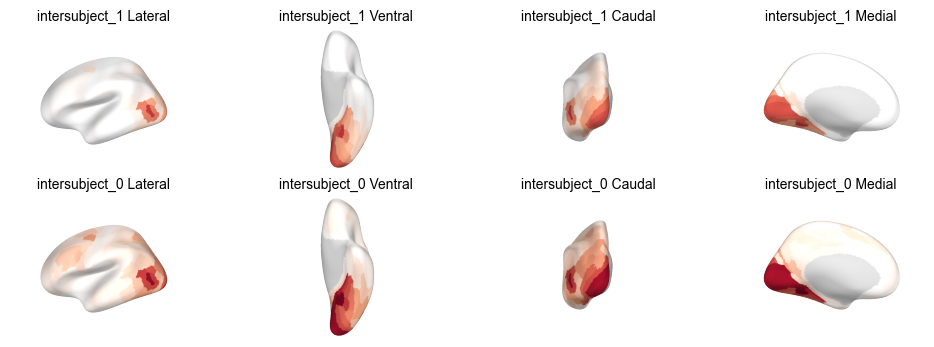

In [ ]:
fig, axes = plt.subplots(len(columns), len(views), figsize=(len(views) * 3, len(columns) * 2))
for i, column in enumerate(columns):
    for j, view in enumerate(views):
        img_file = surface_folder / f"01_shifted_vs_unshifted_{column}_{view}_{vmax:.1f}.png"
        img = plt.imread(img_file)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{column} {view.capitalize()}", fontsize=10)

## 6. Standalone colorbar

Export a 0→0.30 bar for reuse in the manuscript.


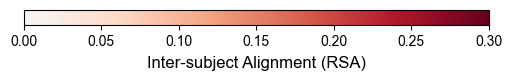

In [6]:
vmax = 0.3
title = r"Inter-subject Alignment (RSA)"
filename = output_folder / f"01_colorbar_{vmax:.2f}_BuRd.pdf"
plot_cbar_set(title=title, filename=filename, vmin=0, vmax=vmax, locator=0.05)

## 7. Power‑law relationship (IS‑1 → IS‑0)

Fit  

$$
\text{IS-0} = \alpha\,(\text{IS-1})^\beta
$$

using a zero‑intercept power law with bootstrap CI. A tiny ε shift avoids log(0).  

**Outcome:** High $R^2$ (legend), confirming that IS‑0 can be predicted from IS‑1 by a simple attenuation curve. The exponent >1 would indicate stronger suppression of weak parcels by shifting. 

This indicates that information in frontal areas is more suppressed by shifting than in visual areas, which is consistent with the idea that frontal areas are more susceptible to trial‑locked noise. This is also consistent with the comparison of networks shifted vs unshifted (notebook 05_rsa_networks), that showed that is not only a uniform suppresion, but key parcels like FEF lost their role in the network when shifting was applied.



Pseudo-R²: 0.965 N Boostrap samples: 10000


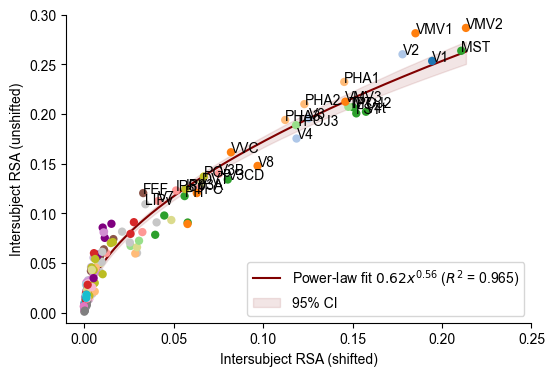

In [7]:
# Get color palette for areas
palette = df[["area", "area_color"]].drop_duplicates().set_index("area").area_color.to_dict()



# Small shift to avoid log(0) issues
n_boot = 10000
eps = 1e-6  
a = df.intersubject_1.min() - eps
b = df.intersubject_0.min() - eps

x_fit, y_fit, y_lower, y_upper, r2, params =  fit_powerlaw_zero_with_bootstrap(
    df.intersubject_1 - a, df.intersubject_0 - b, n_boot=1000, p0=[1, 0.5], n_points=200);

label = f"Power-law fit ${params[0]:.2f}x^{{{params[1]:.2f}}}$ ($R^2$ = {r2:.3f})"

# Plot curve fit
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x_fit + a, y_fit + b, color='maroon', label=label, zorder=-10)
ax.fill_between(x_fit + a, y_lower + b, y_upper + b, color='maroon', alpha=0.1, label='95% CI', zorder=-20)
print(f"Pseudo-R²: {r2:.3f} N Boostrap samples: {n_boot}")
ax.legend(loc="lower right", fontsize=10)

# Plot scatter
sns.scatterplot(
    data=df,
    x="intersubject_1",
    y="intersubject_0",
    hue="area",
    ax=ax,
    legend=False,
    palette=palette,
    lw=0,
)

# Adjust plot
ax.set_xlim(-0.01, 0.25)
ax.set_ylim(-0.01, 0.3)
ax.set_xlabel("Intersubject RSA (shifted)")
ax.set_ylabel("Intersubject RSA (unshifted)")
sns.despine(ax=ax)

# Save in pdf without text annotations
filename = output_folder / "02_shift_0_vs_shift_1_isrsa.pdf"
fig.savefig(filename, bbox_inches="tight", transparent=True)

# Add text annotations
top_30 = df.nlargest(30, "intersubject_0")
for i, row in top_30.iterrows():
    ax.text(row["intersubject_1"], row["intersubject_0"], row["name"])

# Save in svg with text annotations for manual editing
fig.savefig(filename.with_suffix(".svg"), bbox_inches="tight", transparent=True)

## 8. Parcel‑wise correlations

Report Spearman (monotonic) and Pearson (linear) correlations between IS‑0 and IS‑1. Supporting near‑rank‑preserving attenuation.


In [8]:
r, p_value = spearmanr(df.intersubject_0, df.intersubject_1)
print(f"Spearman correlation: {r:.3f}, p-value: {p_value:.3e}")
r, p_value = pearsonr(df.intersubject_0, df.intersubject_1)
print(f"Pearson correlation: {r:.3f}, p-value: {p_value:.3e}")

Spearman correlation: 0.958, p-value: 2.811e-98
Pearson correlation: 0.963, p-value: 0.000e+00


## 9. Area legend (color swatches)

Generate a compact legend mapping HCP macro‑areas to the scatter colors; saved as a separate PDF for panel assembly.


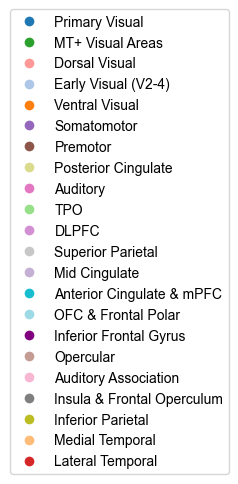

In [9]:
fig, ax = plt.subplots(figsize=(2, 1))
ax.axis("off")
# Use labels and handles
handles = []
labels = []
for area, color in palette.items():
    handles.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=area,
            markerfacecolor=color,
            markersize=8,
            markeredgecolor="white",
        )
    )
    labels.append(area)

ax.legend(handles=handles, labels=labels, loc="center", ncol=1)
filename = output_folder / "03_legend_areas.pdf"
fig.savefig(filename, bbox_inches="tight", transparent=True)



- **Shifted vs Unshifted:** Temporal shifting mainly rescales RSA scores; spatial structure is preserved.  
- **Power‑law fit:** A single curve explains IS‑0 from IS‑1, reinforcing that both probe the same latent geometry with different noise floors.  
- **Practical choice:** IS‑1 is stricter (less stimulus‑locked noise), IS‑0 yields slightly higher absolute values. Either is valid; interpretations are robust across both.


Sanity check: Shift 1 vs Shift 2 strategy

When performing the shifting, shift = 1 (repetitions 1->2, 2->3, 3->1), should be mathematically equivalent to shift = 2 (repetitions 1->3, 2->1, 3->2) when aggregating across all subjects, due to symmetry in the participant roles. But at level participant would vary slightly. 

Check this



In [10]:
df_1 = pd.read_parquet(filename_rsa_1).query("roi_x == roi_y and subject_i != subject_j")
df_1 = df_1[["roi_x", "subject_i", "subject_j", "similarity"]]
df_1 = df_1.rename(columns={"similarity": "rsa_shift_1", "roi_x": "roi"})
df_2 = pd.read_parquet(filename_rsa_2).query("roi_x == roi_y and subject_i != subject_j")
df_2 = df_2[["roi_x", "subject_i", "subject_j", "similarity"]]
df_2 = df_2.rename(columns={"similarity": "rsa_shift_2", "roi_x": "roi"})

# Merge both DataFrames on 'roi' and average across subjects
df_1_2_merged = pd.merge(df_1, df_2, on=["roi", "subject_i", "subject_j"])
df_1_2_merged["diff_1_2"] = df_1_2_merged["rsa_shift_1"] - df_1_2_merged["rsa_shift_2"]

print("Max difference:", df_1_2_merged["diff_1_2"].abs().max())

# We see that at individual level, are similar but not identical
df_1_2_merged

Max difference: 0.06845531


,roi,subject_i,subject_j,rsa_shift_1,rsa_shift_2,diff_1_2
0,1,1,2,0.305997,0.306219,-0.000222
1,2,1,2,0.303054,0.301955,0.001099
2,3,1,2,0.015745,0.017472,-0.001728
3,4,1,2,0.263830,0.253253,0.010577
4,5,1,2,0.272081,0.271161,0.000921
...,...,...,...,...,...,...
10075,176,8,7,0.001468,0.002893,-0.001426
10076,177,8,7,0.004749,0.003638,0.001111
10077,178,8,7,-0.000176,0.000849,-0.001024
10078,179,8,7,-0.002261,0.001449,-0.003711


Both group level are completly identical (up to numerical precisioon. The max difference is <1e-8).
We can safely assume that the two strategies are equivalent, and we can use the shift 1 strategy for the rest of the analysis.

In [11]:
df_1_2_merged_grouped = df_1_2_merged.groupby(["roi"]).aggregate(
    {
        "rsa_shift_1": "mean",
        "rsa_shift_2": "mean",
    }
).reset_index()
df_1_2_merged_grouped["diff_1_2"] = df_1_2_merged_grouped["rsa_shift_1"] - df_1_2_merged_grouped["rsa_shift_2"]


print("Max difference:", df_1_2_merged_grouped["diff_1_2"].abs().max())

df_1_2_merged_grouped

Max difference: 2.2351742e-08


,roi,rsa_shift_1,rsa_shift_2,diff_1_2
0,1,0.194511,0.194511,-1.490116e-08
1,2,0.210775,0.210775,0.000000e+00
2,3,0.012278,0.012278,-9.313226e-10
3,4,0.177940,0.177940,0.000000e+00
4,5,0.125448,0.125448,0.000000e+00
...,...,...,...,...
175,176,0.004292,0.004292,0.000000e+00
176,177,0.001881,0.001881,0.000000e+00
177,178,0.000320,0.000320,-2.910383e-11
178,179,0.001305,0.001305,-2.328306e-10
